# Image Classification with a Convolutional Neural Network

Convolutional Neural Networks (CNNs) are typically comprised of a series of convolutional layers, which reduce the dimensionality of an image using learned convolutional filters, followed by a more typical series of linear layers which are better suited to the task we are interested in, which in this case is prediction. The final layer of the network in this case consists of 10 outputs, corresponding to the number of classes we wish to classify our images.

## Dataset

For this task, we will use the `CIFAR10` dataset. The images in this dataset belong to 10 distinct classes, and have images of size 3x32x32.


100.0%


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


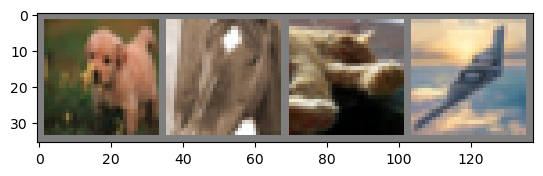

dog   horse cat   plane


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

transform = transforms.Compose([ transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) ])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='../data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='../data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

# Define the Neural Network

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 3 input image channel, 6 output channels, 5x5 square convolution kernel
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5*5 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, input):
        
        # Convolution layer C1: 1 input image channel, 6 output channels,
        # 5x5 square convolution, it uses RELU activation function, and
        # outputs a Tensor with size (N, 6, 28, 28), where N is the size of the batch
        c1 = F.relu(self.conv1(input))
        
        # Subsampling layer S2: 2x2 grid, purely functional,
        # this layer does not have any parameter, and outputs a (N, 6, 14, 14) Tensor
        s2 = F.max_pool2d(c1, (2, 2))
        
        # Convolution layer C3: 6 input channels, 16 output channels,
        # 5x5 square convolution, it uses RELU activation function, and
        # outputs a (N, 16, 10, 10) Tensor
        c3 = F.relu(self.conv2(s2))
        
        # Subsampling layer S4: 2x2 grid, purely functional,
        # this layer does not have any parameter, and outputs a (N, 16, 5, 5) Tensor
        s4 = F.max_pool2d(c3, 2)
        
        # Flatten operation: purely functional, outputs a (N, 400) Tensor
        s4 = torch.flatten(s4, 1)
        
        # Fully connected layer F5: (N, 400) Tensor input, and outputs a (N, 120) Tensor, it uses RELU activation function
        f5 = F.relu(self.fc1(s4))
        
        # Fully connected layer F6: (N, 120) Tensor input, and outputs a (N, 84) Tensor, it uses RELU activation function
        f6 = F.relu(self.fc2(f5))
        
        # Gaussian layer OUTPUT: (N, 84) Tensor input, and outputs a (N, 10) Tensor
        output = self.fc3(f6)
        return output

## Understanding The Conv2d Layer

In [4]:
import torch.nn as nn
nn.Conv2d?

Init signature:
nn.Conv2d(
    in_channels: int,
    out_channels: int,
    kernel_size: Union[int, Tuple[int, int]],
    stride: Union[int, Tuple[int, int]] = 1,
    padding: Union[str, int, Tuple[int, int]] = 0,
    dilation: Union[int, Tuple[int, int]] = 1,
    groups: int = 1,
    bias: bool = True,
    padding_mode: str = 'zeros',
    device=None,
    dtype=None,
) -> None
Docstring:     
Applies a 2D convolution over an input signal composed of several input
planes.

In the simplest case, the output value of the layer with input size
:math:`(N, C_{\text{in}}, H, W)` and output :math:`(N, C_{\text{out}}, H_{\text{out}}, W_{\text{out}})`
can be precisely described as:

.. math::
    \text{out}(N_i, C_{\text{out}_j}) = \text{bias}(C_{\text{out}_j}) +
    \sum_{k = 0}^{C_{\text{in}} - 1} \text{weight}(C_{\text{out}_j}, k) \star \text{input}(N_i, k)


where :math:`\star` is the valid 2D `cross-correlation`_ operator,
:math:`N` is a batch size, :math:`C` denotes a number of channels,
:

The arguments:
- `in_channels` roughly corresponds to the number of colours in the image, this should be set to 1 if we want to consider monochromatic images.
- `kernel_size` determines the size of the kernel used for the convolution. When specified as an int this generates a square kernel, when specified as a Tuple the kernel may be rectangular.
- `padding` adds an outer layer to the input sample, which can help us create a larger size for the layer's output . `padding_mode` determines which values should be used for the padded pixels - the most common choice is ot pad it with zeros.
- `dilation` refers to the spacing between the pixels of the kernel. By default the `dilation` is `1`.

## Pooling

The two most common pooling methods are called average pooling and max pooling. Pooling reduces the spatial dimensions (height and width) of the feature map while retaining important information. In the case of max pooling, It it does so by taking the maximum value within a sliding window (pooling window) and moves the window across the input feature map. The downsampling factor is determined by the pooling window size (kernel size) and stride.

For example, in the code above, `F.max_pool2d(c1, (2, 2))` applies max pooling to the `c1` feature map with a 2x2 pooling window.

## Examining the Network

The free parameters of the network are returned by `net.parameters()`.

In [5]:
net = Net()
print(net)

params = list(net.parameters())
print(len(params))
print(params[0].size())  # conv1's .weight

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
10
torch.Size([6, 3, 5, 5])


# Loss Function

PyTorch's `nn` package provides many possible [loss functions](https://pytorch.org/docs/nn.html#loss-functions) to choose from. 

`nn.MSELoss`, is a simple loss that computes the mean-squared error between the ouptut and the target.

However for this example we will use a Classification Cross-Entropy loss and SGD with momentum.

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Training

In [7]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.239
[1,  4000] loss: 1.869
[1,  6000] loss: 1.683
[1,  8000] loss: 1.572
[1, 10000] loss: 1.537
[1, 12000] loss: 1.469
[2,  2000] loss: 1.388
[2,  4000] loss: 1.399
[2,  6000] loss: 1.348
[2,  8000] loss: 1.320
[2, 10000] loss: 1.325
[2, 12000] loss: 1.294
Finished Training


# Test the CNN Predictions

The following code renders 4 examples from the test set and prints both the true classifications and the classifications predicted by the network.

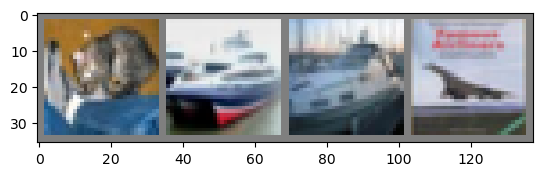

GroundTruth: cat  	Predicted: cat  
GroundTruth: ship 	Predicted: ship 
GroundTruth: ship 	Predicted: ship 
GroundTruth: plane	Predicted: ship 


In [11]:
dataiter = iter(testloader)
images, labels = next(dataiter)

_, predicted = torch.max(net(images), 1)

# print images
imshow(torchvision.utils.make_grid(images))
for i in range(4):
	print(f'GroundTruth: {classes[labels[i]]:5s}'+"\t"+f'Predicted: {classes[predicted[i]]:5s}')

Let us now test the network's performance on the whole test set.

In [12]:
correct = 0
total = 0
# No need to calculate the gradients for our outputs
with torch.no_grad():
	for data in testloader:
		images, labels = data
		# calculate outputs by running images through the network
		outputs = net(images)
		# the class with the highest energy is what we choose as prediction
		_, predicted = torch.max(outputs.data, 1)
		total += labels.size(0)
		correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 53 %


The following code lets us see how the network performed on some of each of the classes.

In [13]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# No gradients needed
with torch.no_grad():
	for data in testloader:
		images, labels = data
		outputs = net(images)
		_, predictions = torch.max(outputs, 1)
		# collect the correct predictions for each class
		for label, prediction in zip(labels, predictions):
			if label == prediction:
				correct_pred[classes[label]] += 1
			total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 53.8 %
Accuracy for class: car   is 62.0 %
Accuracy for class: bird  is 45.6 %
Accuracy for class: cat   is 26.2 %
Accuracy for class: deer  is 40.0 %
Accuracy for class: dog   is 41.2 %
Accuracy for class: frog  is 77.8 %
Accuracy for class: horse is 68.8 %
Accuracy for class: ship  is 79.1 %
Accuracy for class: truck is 44.4 %
